In [2]:
import pandas as pd
import numpy as np
from sympy import Matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import skew, kurtosis, norm
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../homework')
from Functions import *

In [3]:
factors_er=pd.read_excel('../../finm-portfolio-2022/data/final_exam_data.xlsx',sheet_name='factors (excess returns)')
futures_er=pd.read_excel('../../finm-portfolio-2022/data/final_exam_data.xlsx',sheet_name='futures (excess returns)')
forecasting=pd.read_excel('../../finm-portfolio-2022/data/final_exam_data.xlsx',sheet_name='forecasting (weekly)')
fx_daily=pd.read_excel('../../finm-portfolio-2022/data/final_exam_data.xlsx',sheet_name='fx (daily)')

In [4]:
calculate_statistics(forecasting, 52, 0.05, 0.05, False)

,GLD,Tbill rate,Tbill change
mean,0.057953,29.082315,0.297831
volatility,0.152181,6.151280,0.397789
sharpe,0.380816,4.727848,0.748716
skewness,-0.253698,1.760331,-3.686273
kurtosis,1.472098,2.531876,76.134686
VaR,-0.033323,0.005000,-0.045000
CVaR,-0.047125,-0.002706,-0.106389


In [5]:
norm.ppf(0.05)*forecasting['GLD'].std()

-0.034736968469478054

In [6]:
rolling_calc=forecasting.copy()
rolling_calc['temp']=forecasting['GLD'].shift(1).rolling(150).std()
rolling_calc.dropna(inplace=True)
rolling_calc['Var']=rolling_calc['temp']*norm.ppf(0.05)
rolling_calc.tail()

,Date,GLD,Tbill rate,Tbill change,temp,Var
707,2022-11-06,0.021611,4.013,0.043,0.022781,-0.037472
708,2022-11-13,0.051703,4.063,0.050,0.022843,-0.037574
709,2022-11-20,-0.010756,4.135,0.072,0.023164,-0.038101
710,2022-11-27,0.002641,4.175,0.040,0.023103,-0.038000
711,2022-12-04,-0.003002,4.253,0.078,0.023097,-0.037992


In [7]:
reg=run_regression(futures_er, factors_er[['MKT','UMD']])
reg

,alpha,beta_MKT,beta_UMD,r2
NG1,0.111955,0.354111,0.381230,0.017306
KC1,0.023200,0.315122,-0.027467,0.025887
CC1,0.070793,0.207322,-0.035816,0.012031
LB1,0.064476,0.942075,-0.004789,0.136850
CT1,0.024917,0.504249,-0.178597,0.099020
SB1,0.093130,0.057967,-0.319205,0.032730
LC1,0.015422,0.183059,0.066096,0.020046
W1,0.054533,0.298899,0.022426,0.021333
S1,0.042542,0.399481,0.027260,0.052917
C1,0.060871,0.340399,0.062038,0.028248


In [8]:
np.abs(reg['alpha']).mean()

0.0589189322804815

In [9]:
np.abs(reg['r2'].mean())

0.05874717942946513

In [10]:
model=LinearRegression()
model.fit(reg[['beta_MKT','beta_UMD']],futures_er.iloc[:,1:].mean()*12)
print(model.intercept_)
print(model.coef_)
print(model.score(reg[['beta_MKT','beta_UMD']],futures_er.iloc[:,1:].mean()*12))
print(mean_absolute_error(futures_er.iloc[:,1:].mean()*12,model.predict(reg[['beta_MKT','beta_UMD']])))

0.06112091018003076
[0.06197424 0.07349761]
0.39137127926546045
0.018001671556518994


In [11]:
factors_er.iloc[:,1:].mean()*12

MKT    0.070633
UMD    0.018405
dtype: float64

In [12]:
model=LinearRegression()
model.fit(forecasting[['Tbill rate','Tbill change']].shift(1).dropna(),forecasting['GLD'].iloc[1:])
print(model.intercept_)
print(model.coef_)
print(model.score(forecasting[['Tbill rate','Tbill change']].shift(1).dropna(),forecasting['GLD'].iloc[1:]))

0.0009926085637549675
[0.00025022 0.00045566]
0.00010651991509946779


In [13]:
wt=0.2+(80*model.predict(forecasting[['Tbill rate','Tbill change']].shift(1).dropna()))
forecast=forecasting[['Date','GLD']].iloc[1:,:].copy()
forecast['wt']=wt
forecast['forecast']=forecast['GLD']*forecast['wt']
forecast.tail()

,Date,GLD,wt,forecast
707,2022-11-06,0.021611,0.361976,0.007823
708,2022-11-13,0.051703,0.361305,0.018681
709,2022-11-20,-0.010756,0.362561,-0.003900
710,2022-11-27,0.002641,0.364805,0.000964
711,2022-12-04,-0.003002,0.364439,-0.001094


In [14]:
tres=calculate_statistics(forecast[['Date','GLD','forecast']], 52, 0.05, 0.05, True)
tres.loc['Max_Drawdown']=tres.loc['Max_Drawdown'].apply(lambda x: x['max_drawdown'])
tres

,GLD,forecast
mean,0.058958,0.017337
volatility,0.152243,0.043543
sharpe,0.387264,0.398157
skewness,-0.256106,-0.213994
kurtosis,1.471829,1.178575
VaR,-0.033328,-0.009688
CVaR,-0.047125,-0.013349
Max_Drawdown,-0.447446,-0.142573


In [15]:
calculate_market_statistics(forecast[['Date','forecast']],forecast['GLD'],52)

,alpha,information_ratio,market_beta,r2,treynor_ratio
forecast,0.000499,0.213643,0.285599,0.997128,0.060704


In [16]:
dates=forecast['Date'][forecast['Date']>='2017']
tdf=forecast.copy()
tdf.drop(columns=['wt'],inplace=True)
tdf['forecast']=np.nan
for i in dates:
    X=forecasting[forecasting['Date']<i][['Tbill rate','Tbill change']].shift(1).dropna()
    y=forecasting[forecasting['Date']<i]['GLD'].iloc[1:]
    model=LinearRegression()
    model.fit(X,y)
    prediction=model.predict(np.array(forecasting[forecasting['Date']<i].iloc[-1][['Tbill rate','Tbill change']]).reshape(1,-1))
    tdf.loc[tdf['Date']==i,'forecast']=prediction

tdf.dropna(inplace=True)
tdf.tail()


/Users/Daniel/miniforge3/envs/UChicago1_mini/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/Daniel/miniforge3/envs/UChicago1_mini/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/Daniel/miniforge3/envs/UChicago1_mini/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/Daniel/miniforge3/envs/UChicago1_mini/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/Daniel/miniforge3/envs/UChicago1_mini/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but

,Date,GLD,forecast
707,2022-11-06,0.021611,0.000558
708,2022-11-13,0.051703,0.001113
709,2022-11-20,-0.010756,0.002521
710,2022-11-27,0.002641,0.002188
711,2022-12-04,-0.003002,0.002199


In [17]:
tdf.head()

,Date,GLD,forecast
402,2017-01-01,0.015566,0.004322
403,2017-01-08,0.019524,0.008297
404,2017-01-15,0.022013,0.004538
405,2017-01-22,0.007355,0.006878
406,2017-01-29,-0.013559,0.010988


In [18]:
temp=forecasting.copy()
temp['cum_mean_forecast']=temp['GLD'].expanding().mean().shift(1)
tdf=pd.merge(tdf,temp[['Date','cum_mean_forecast']],on='Date')

In [19]:
RSS=np.sum((tdf['GLD']-tdf['forecast'])**2)
TSS=np.sum((tdf['GLD']-tdf['cum_mean_forecast'])**2)
print(1-(RSS/TSS))

-0.14488422352127506


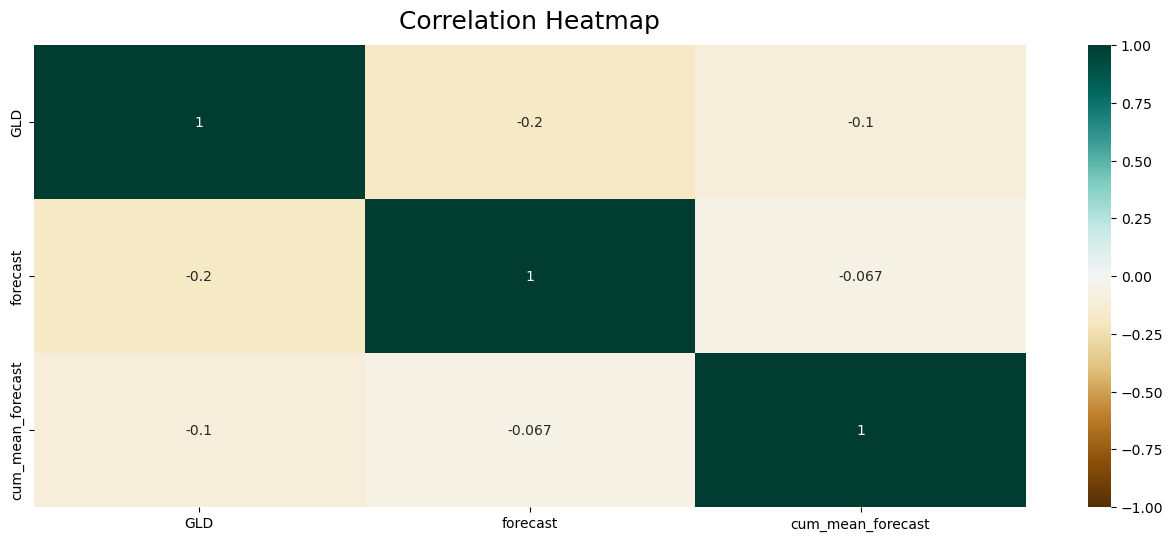

In [20]:
correlation_heatmap(tdf)

In [21]:
tdf['wt_forecast']=0.2+(80*tdf['forecast'])
tdf['wt_cum_mean_forecast']=0.2+(80*tdf['cum_mean_forecast'])
tdf['forecast_ret']=tdf['GLD']*tdf['wt_forecast']
tdf['cum_mean_forecast_ret']=tdf['GLD']*tdf['wt_cum_mean_forecast']

In [22]:
calculate_market_statistics(tdf[['Date','forecast_ret','cum_mean_forecast_ret']],tdf['GLD'],52)

,alpha,market_beta,treynor_ratio,information_ratio,r2
forecast_ret,-0.088990,0.697484,-0.049399,-0.551683,0.257052
cum_mean_forecast_ret,-0.001934,0.295362,0.071641,-1.035912,0.997846


In [23]:
tres=calculate_statistics(tdf[['Date','forecast_ret','cum_mean_forecast_ret']], 52, 0.05, 0.05, True)
tres.loc['Max_Drawdown']=tres.loc['Max_Drawdown'].apply(lambda x: x['max_drawdown'])
tres

,forecast_ret,cum_mean_forecast_ret
mean,-0.034455,0.02116
volatility,0.187143,0.040223
sharpe,-0.184112,0.526073
skewness,-14.191358,-0.248982
kurtosis,232.691396,3.155127
VaR,-0.01251,-0.008968
CVaR,-0.043882,-0.012542
Max_Drawdown,-0.449998,-0.063172


In [24]:
fx_daily['GBP']=np.log(fx_daily['GBP'])
fx_daily['SOFR']=np.log(fx_daily['SOFR']+1)
fx_daily['SONIA']=np.log(fx_daily['SONIA']+1)

In [26]:
fx_daily.mean()

DATE     2020-07-28 11:26:12.010628864
GBP                           0.260081
SOFR                          0.011354
SONIA                          0.00531
dtype: object

In [31]:
ret=fx_daily['GBP'].diff()+fx_daily['SONIA'].shift(1)-fx_daily['SOFR'].shift(1)
ret.dropna(inplace=True)

In [37]:
tstats=calculate_statistics_array(np.array(ret), 252, 0.05, 0.05)
tstats

{'mean': -1.556284892151119,
 'volatility': 0.15030537079088177,
 'sharpe': -10.3541535739023,
 'skewness': -0.16665657164669231,
 'kurtosis': -0.06109081614330103,
 'VaR': -0.02128029267257066,
 'CVaR': -0.024995703021885772}

In [47]:
tarray=np.array(ret-fx_daily['SOFR'].shift(1).dropna())
prob(np.mean(tarray)*252,np.std(tarray)*np.sqrt(252),5)

1.0

In [53]:
model=LinearRegression()
model.fit(np.array((fx_daily['SOFR']-fx_daily['SONIA']).shift(1).dropna()).reshape(-1,1),np.array(fx_daily['GBP'].diff().dropna()).reshape(-1,1))
print(model.intercept_)
print(model.coef_)
print(model.score(np.array((fx_daily['SOFR']-fx_daily['SONIA']).shift(1).dropna()).reshape(-1,1),np.array(fx_daily['GBP'].diff().dropna()).reshape(-1,1)))

[-6.91824338e-05]
[[-0.01063636]]
0.00016217295905862628


In [77]:
trets=model.intercept_[0]+(model.coef_[0][0]-1)*np.array((fx_daily['SOFR']-fx_daily['SONIA']).shift(1).dropna())
pd.DataFrame({'Date':fx_daily['DATE'].iloc[1:],'Excess Return Forecast':trets})

,Date,Excess Return Forecast
1,2018-04-04,-0.013706
2,2018-04-05,-0.012841
3,2018-04-06,-0.012911
4,2018-04-09,-0.012898
5,2018-04-10,-0.012913
...,...,...
1124,2022-11-18,-0.008609
1125,2022-11-21,-0.008600
1126,2022-11-22,-0.008600
1127,2022-11-23,-0.008604
